In [1]:
#import data, modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.optimize as opt
import scipy.stats as stat
#data = open()
#name	longitude	latitude	diameter [km]
data = np.genfromtxt("lunar_craters.dat", delimiter=',')
data = data[: , 1:4]
long = data[: , 0]
lat = data[: , 1]
diameter = data[: , 2]

In [2]:
#truncate data so we only have diameters above 10km, for which the dataset is complete
trunc = diameter >= 10
trunc_data = data[trunc]
diameter_trunc = trunc_data[: , 2]

In [3]:
#truncate the high values of the diameters, just for purposes of the histogram
trunc_high = diameter_trunc <= 200
trunc_high_data = trunc_data[trunc_high]
diameter_trunc_high = trunc_high_data[: , 2]

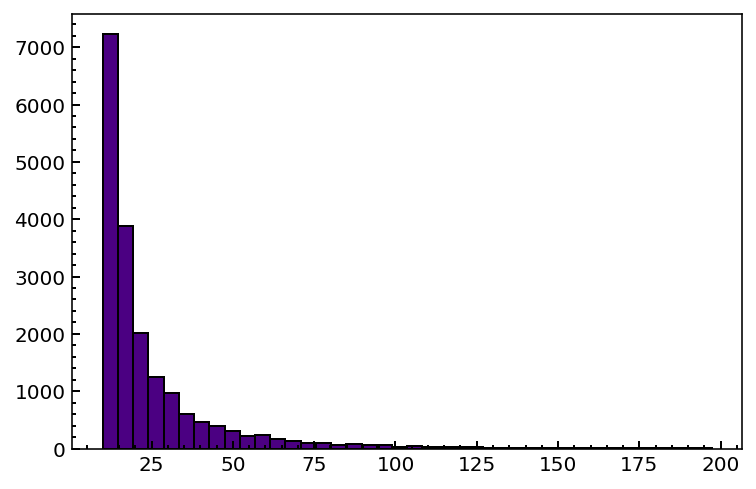

In [4]:
#plot histogram to show distribution of diameters
fig1, ax = plt.subplots()
def setaxparams(): #axis formatting stuff
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=1, direction='in')
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2, direction='in')
setaxparams()

plt.hist(diameter_trunc_high, bins = 40, color = 'indigo', edgecolor='black')
plt.show()

In [5]:
#write power law model as function of d, with two parameters
def power_law(a, dmin, d):
    pdf = (a/dmin)*((d/dmin)**(-a-1))
    return pdf

In [6]:
#define loglike as the log of the product of pdf values
def log_like(a, diams):
    prod = np.sum(np.log(power_law(a, 10, diams), dtype = np.float128))
    return prod

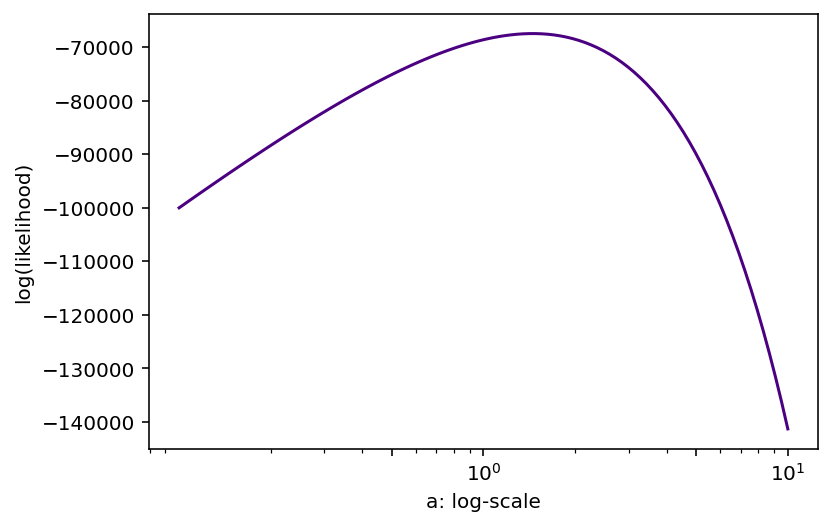

In [7]:
#plot how loglike varies with variation in a parameter
fig1, ax = plt.subplots()

aa = np.exp(np.linspace(np.log(0.1), np.log(10), num = 100))
xx = np.exp(np.linspace(np.log(0.1), np.log(10), num = 20))
XX = [0.5, 1, 5, 10]
ax.set_xscale("log")
plt.xticks(ticks = XX)
log_like_a = np.zeros(len(aa))
for i in range (0, len(aa)):
    log_like_a[i] = log_like(aa[i], diameter_trunc)
plt.plot(aa, log_like_a, color = 'indigo')
plt.xlabel('a: log-scale')
plt.ylabel('log(likelihood)')
plt.show()

In [8]:
#write function to estimate a using the loglike/a relationship
def estimate_a(diam, a_max):
    aaa = np.exp(np.linspace(np.log(0.1), np.log(a_max), num = 100))
    log_like_a = np.zeros(len(aaa))
    for i in range (0, len(aaa)):
        log_like_a[i] = log_like(aaa[i], diam)
    max_est_arg = np.argmax(log_like_a)
    #argmax finds the best a, but only among values plotted
    max_est = aaa[max_est_arg]
    return max_est

In [9]:
#write function to take derivative of power law function with respect to a, 
#so that d/da can be used as a function with newton's method
def d_power_law(a, diam):
    a_delta_plus = a + 1e-6
    a_delta_minus = a - 1e-6
    deriv_plus = (log_like(a_delta_plus, diam) - log_like(a, diam))/(1e-6)
    deriv_minus = (log_like(a, diam) - log_like(a_delta_minus, diam))/(1e-6)
    deriv = (deriv_plus + deriv_minus)/2
    return deriv

In [10]:
#use newton's method to narrow down best a further
#both last function and this use diameters as a flexible input
#so that performing operations on several datasets becomes more flexible
def newton(diam, a):
    def d_power_a(x):
        deriv = d_power_law(x, diam)
        return deriv
    a_best = opt.newton(d_power_a, a)
    return a_best

In [11]:
#use new function to find best a for dataset
a_best = newton(diameter_trunc, 1)
print ("Best Value for a: ", a_best)

Best Value for a:  1.452034497196864696


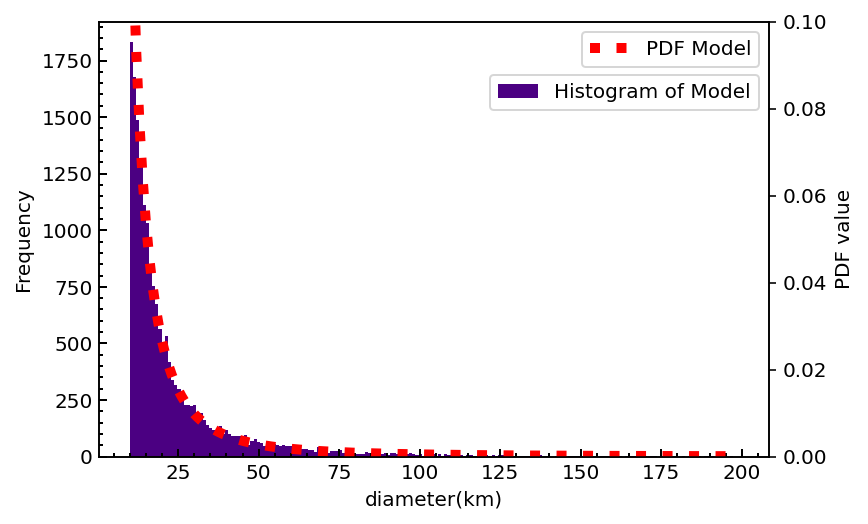

In [12]:
#compare model pdf with frequencies of data
fig1, ax = plt.subplots()
plt.hist(diameter_trunc_high, bins = 190, label = "Histogram of Model", color = 'indigo')
model_range = np.arange(10, 200, 1)
model_plot = power_law(a_best, 10, model_range)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

plt.xlabel('diameter(km)')
plt.ylabel('Frequency')
plt.twinx()
#use two y axes to account for differences in scale
plt.plot(model_range, model_plot, label = "PDF Model", color = 'r', linewidth=5, linestyle = ':')
plt.ylim(0, 0.1)
plt.ylabel('PDF value')
plt.legend()
setaxparams()
plt.show()

In [13]:
#slice datasets into longitude/latitude sections
delt = 30
long_divs = np.arange(-180, 180, delt)
long_divs = np.concatenate((long_divs, [180]))
lat_divs = np.sin(np.pi*np.arange(-90, 90, delt)/180)*90
lat_divs = np.concatenate((lat_divs, [90]))

In [14]:
#for the latitude, use sincurve to make turn evenly spaced degrees into degrees that connote equal areas
def weighted(lat):
    lat_weights = np.sin(np.pi*lat/180)*90
    return lat_weights

In [15]:
#function that finds optimal a parameter for data in each division 
def frequency_map(long_divs, lat_divs, data):
    frequency_map = np.zeros((len(lat_divs) - 1, len(long_divs) - 1))
    for ii in range (0, len(lat_divs) - 1):
        for jj in range (0, len(long_divs) - 1):
            long_slice = data[np.logical_and(data[: , 0] >= long_divs[jj], 
                                                   data[: , 0] < long_divs[jj+1])]
            lat_long_slice = long_slice[np.logical_and(long_slice[: , 1] >= lat_divs[ii], 
                                                       long_slice[: , 1] < lat_divs[ii+1])]
            sliced_diams = lat_long_slice[:, 2]
            est = estimate_a(sliced_diams, 10)
            a = newton(sliced_diams, est)
            frequency_map[ii, jj] = a
    return frequency_map

In [16]:
#function that does the same, but only using longitudinal slices
def frequency_map_long(long_divs, data):
    frequency_map = np.zeros(len(long_divs) - 1)
    for jj in range (0, len(long_divs) - 1):
        long_slice = data[np.logical_and(data[: , 0] >= long_divs[jj], 
                                               data[: , 0] < long_divs[jj+1])]
        sliced_diams = long_slice[:, 2]
        est = estimate_a(sliced_diams, 10)
        a = newton(sliced_diams, est)
        frequency_map[jj] = a
    return frequency_map

In [17]:
#function that does the same, but only using latitudinal slices
def frequency_map_lat(lat_divs, data):
    frequency_map = np.zeros(len(lat_divs) - 1)
    for ii in range (0, len(lat_divs) - 1):
            lat_slice = data[np.logical_and(data[: , 1] >= lat_divs[ii], 
                                                       data[: , 1] < lat_divs[ii+1])]
            sliced_diams = lat_slice[:, 2]
            est = estimate_a(sliced_diams, 10)
            a = newton(sliced_diams, est)
            frequency_map[ii] = a
    return frequency_map

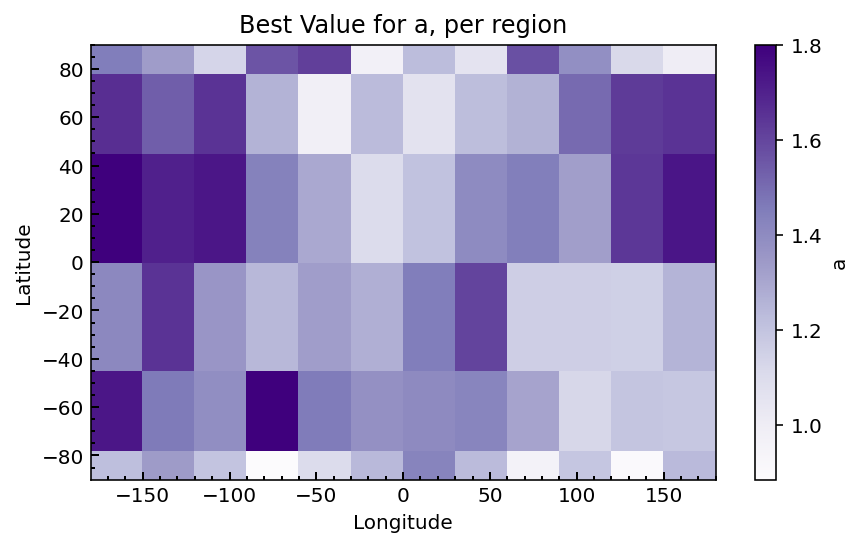

CPU times: user 746 ms, sys: 31.5 ms, total: 777 ms
Wall time: 860 ms


In [18]:
%%time
#create map of a values -- which we are using as a proxy for frequency -- at each region
fig1, ax = plt.subplots(figsize=(7, 4))
frequency_map_first = frequency_map(long_divs, lat_divs, trunc_data)
plt.pcolormesh(long_divs, lat_divs, frequency_map_first, cmap = 'Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label = 'a')
plt.title('Best Value for a, per region')
setaxparams()
plt.show()

In [19]:
#find standard deviation of this map, as well as similar maps that use only long or lat divisions
std_sq = np.std(frequency_map_first)
std_long  = np.std(frequency_map_long(long_divs, trunc_data))
std_lat  = np.std(frequency_map_lat(lat_divs, trunc_data))
print(std_sq, std_long, std_lat)

0.225700601904259 0.1311119072726143 0.1349974100312225


In [20]:
#function that creates similar map, but counts total number of crater hits rather than a value
def frequency_count_map(long_divs, lat_divs, data):
    frequency_map = np.zeros((len(lat_divs) - 1, len(long_divs) - 1))
    for ii in range (0, len(lat_divs) - 1):
        for jj in range (0, len(long_divs) - 1):
            long_slice = data[np.logical_and(data[: , 0] >= long_divs[jj], 
                                                   data[: , 0] < long_divs[jj+1])]
            lat_long_slice = long_slice[np.logical_and(long_slice[: , 1] >= lat_divs[ii], 
                                                       long_slice[: , 1] < lat_divs[ii+1])]
            sliced_diams = lat_long_slice[:, 2]
            freq = len(sliced_diams)
            frequency_map[ii, jj] = freq
    return frequency_map

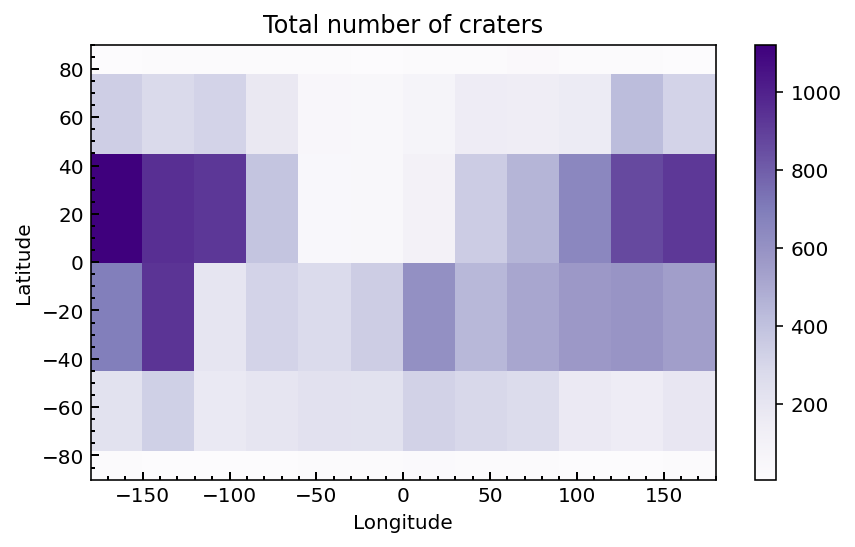

In [21]:
#plot map of raw numbers created above
fig1, ax = plt.subplots(figsize=(7, 4))
frequency_count_map_first = frequency_count_map(long_divs, lat_divs, trunc_data)
plt.pcolormesh(long_divs, lat_divs, frequency_count_map_first, cmap = 'Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('Total number of craters')
setaxparams()
plt.show()

In [22]:
%%time
#smooth kernel map
smooth_delt = 1
window_size = 30
frequency_map_smooth = np.zeros((int(180/smooth_delt -  window_size), int(360/smooth_delt)))
longs_smooth = np.arange(-180, 180, smooth_delt)
lats_smooth = np.arange(-90, 90, smooth_delt)
lats_weighted = weighted(lats_smooth)


for ii in range(0, len(longs_smooth)):
    #the key here is to use the same technique as before,
    #but instead of looping over a set of divisions,
    #use a larger moving window
    long_bounds = np.array([longs_smooth[ii] - window_size/2 , longs_smooth[ii] + window_size/2])
    long_slice_smooth = trunc_data[np.logical_or(np.logical_or(np.logical_and(trunc_data[: , 0] >= long_bounds[0], 
                                                                 trunc_data[: , 0] < long_bounds[1]), 
                                                    np.logical_and(trunc_data[: , 0] - 360 >= long_bounds[0], 
                                                                 trunc_data[: , 0] - 360 < long_bounds[1])), 
                                                    np.logical_and(trunc_data[: , 0] + 360 >= long_bounds[0], 
                                                                 trunc_data[: , 0] + 360 < long_bounds[1]))]
                                                    #these lines of code are to make sure that windows wrap around
    
    
    for jj in range(0, int(len(lats_smooth)- window_size)):
        jjj = int(jj+window_size/2)
        lat_bounds = np.array([weighted(lats_smooth[jjj] - window_size/2), weighted(lats_smooth[jjj] + window_size/2)])
        lat_long_slice_smooth = long_slice_smooth[np.logical_and(long_slice_smooth[: , 1] >= lat_bounds[0], 
                                                            long_slice_smooth[: , 1] < lat_bounds[1])]
        
        #wrapping around doesn't make sense here
        sliced_diams_smooth = lat_long_slice_smooth[:, 2]
        est = estimate_a(sliced_diams_smooth, 10)
        a = newton(sliced_diams_smooth, est)
        frequency_map_smooth[jj, ii] = a

CPU times: user 4min 59s, sys: 2.83 s, total: 5min 2s
Wall time: 5min 33s


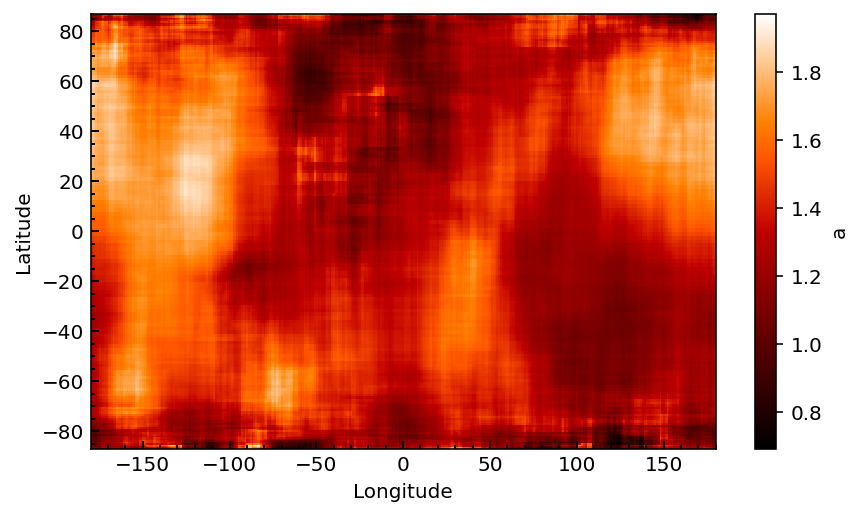

In [23]:
#plot it!!!!!
fig1, ax = plt.subplots(figsize=(7, 4))
lats_weighted_cut = lats_weighted[int(window_size/2):int(- window_size/2 +1)]
longs_smooth_bounded = np.concatenate((longs_smooth, [180]))
plt.pcolormesh(longs_smooth_bounded, lats_weighted_cut, frequency_map_smooth, shading='flat', cmap = 'gist_heat')
plt.colorbar(label = 'a')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
setaxparams()
plt.show()

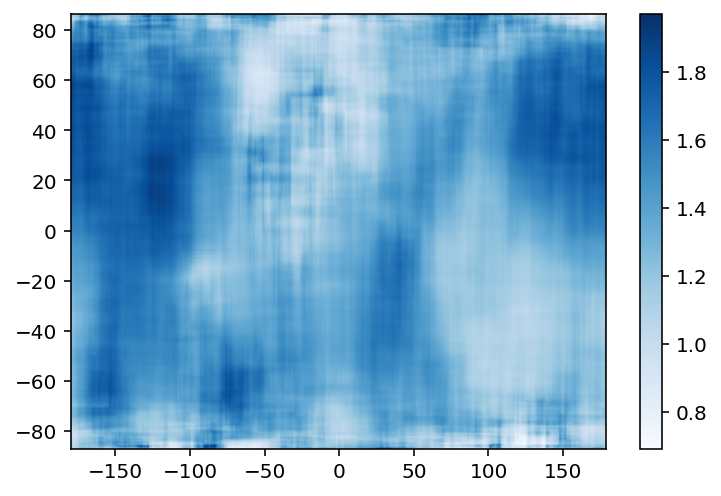

In [24]:
#same plot, different shading technique
plt.pcolormesh(longs_smooth_bounded[:-1], lats_weighted_cut[:-1], frequency_map_smooth, shading='gouraud', cmap = 'Blues')
plt.colorbar()

In [25]:
#standard deviation of colormesh values, while we're at it
std_smooth = np.std(frequency_map_smooth)
print(std_smooth)

0.2148268453830782


In [26]:
#formula for infinite integral calculated analytically
#fraction of craters over X amount
rE = 6371.0
rM = 1737.4
frac_land = 0.291
age_E = 4.54e9

def ext_int(a, dat):
    prob_100 = (10/100)**(a)
    total_100_moon = prob_100*len(dat)
    ratio_earth_moon = (rE/rM)**2
    total_100_earth = total_100_moon * ratio_earth_moon
    land_100_earth = total_100_earth * frac_land
    extinction_interval = age_E/land_100_earth
    return extinction_interval

In [27]:
#calculate extinction interval
extinction_interval = ext_int(a_best, trunc_data[:,2])
print("According to the model, Earth gets hit by an extinction-level impact every", extinction_interval, "years.")

According to the model, Earth gets hit by an extinction-level impact every 1761582.3452717305083 years.


In [28]:
#import data with lunar geologic era attached
#Longitude Latitude Diameter [km] AgeClass
#Age class (1 Pre-Nectarian, 2 Nectarian, 3 Lower Imbrian, 4 Upper Imbrian, 5 Eratosthenian, 6 Copernican)
#(Wilhelms, 1987; Wilhelms, personal communication, 2008; Wilhelms and Byrne, 2009)

data_age = np.genfromtxt("Lunar_Craters_Ages.dat", delimiter = ',')
diam_age = data_age[: , 2]
trunc_age = diam_age >= 10
data_age_trunc = data_age[trunc_age]
age_class = data_age_trunc[:, 3]
prenec = data_age_trunc[age_class == 1]
nec = data_age_trunc[age_class == 2]
low_imb = data_age_trunc[age_class == 3]
up_imb = data_age_trunc[age_class == 4]
erato = data_age_trunc[age_class == 5]
cop = data_age_trunc[age_class == 6]
age_sort = [prenec, nec, low_imb, up_imb, erato, cop]

In [29]:
#calculate the optimal a value for data from each age
labels_ages = ('Pre-Nectarian', 'Nectarian', 'Lower Imbrian', 'Upper Imbrian', 'Eratosthenian','Copernican')

a_age = np.zeros(6)
ext_int_age = np.zeros(6)
for ii in range (0, 6):
    est = estimate_a(age_sort[ii][:, 2], 1)
    a = newton(age_sort[ii][:, 2], est)
    a_age[ii] = a
    ext_int_age[ii] = ext_int(a, age_sort[ii][:, 2])
    #also calculate the extinction impact interval from each era

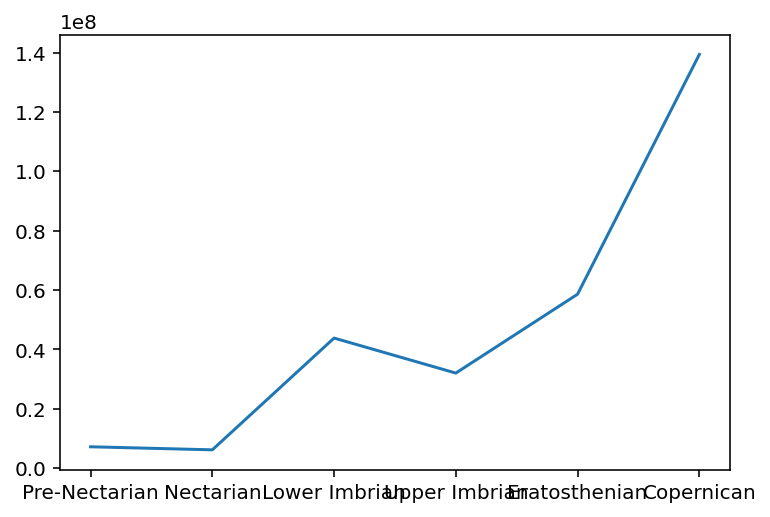

In [30]:
#plot the extinction impact interval from each era
plt.plot(labels_ages, ext_int_age)

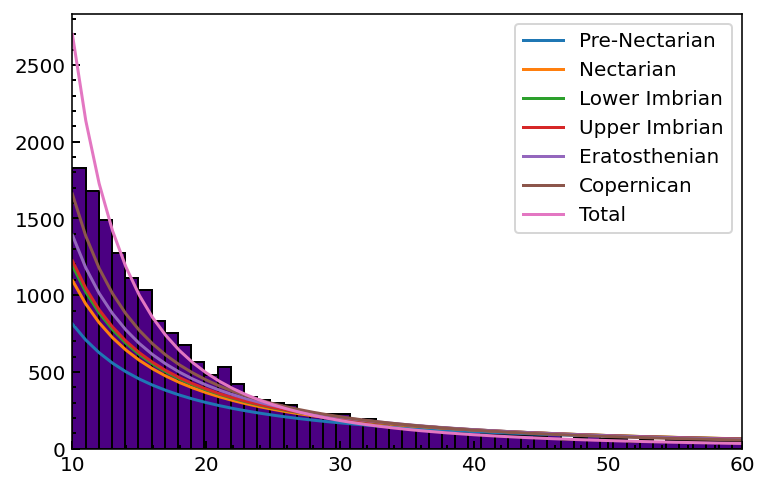

In [31]:
#compare power law models with each era's a value
#with histogram of total data

fig1, ax = plt.subplots()

plt.hist(diameter_trunc_high, bins = 190, color = 'indigo', edgecolor='black')
model_range = np.arange(10, 200, 1)
model_plot = power_law(a_best, 10, model_range)*len(diameter_trunc_high)
for i in range(6):
    model_plot_age = power_law(a_age[i], 10, model_range)*len(diameter_trunc_high)
    plt.plot(model_range, model_plot_age, label = labels_ages[i])
plt.plot(model_range, model_plot, label = 'Total')

plt.xlim(10, 60)  
setaxparams()
plt.legend()
plt.show()

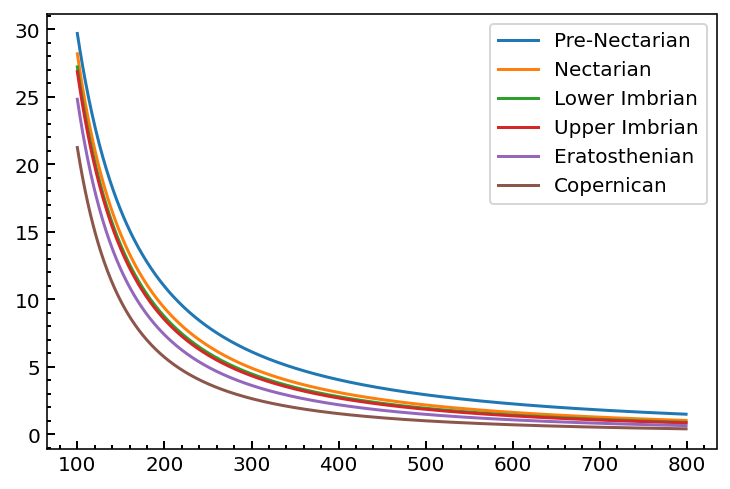

In [32]:
#compare all of the models for craters above 100km (extinction level)
#notice how the pdfs have flipped
fig1, ax = plt.subplots()

model_range = np.arange(100, 800, 1)
for i in range(6):
    model_plot_age = power_law(a_age[i], 10, model_range)*len(diameter_trunc_high)
    plt.plot(model_range, model_plot_age, label = labels_ages[i])
#plt.xlim(10, 60)  
setaxparams()
plt.legend()
plt.show()

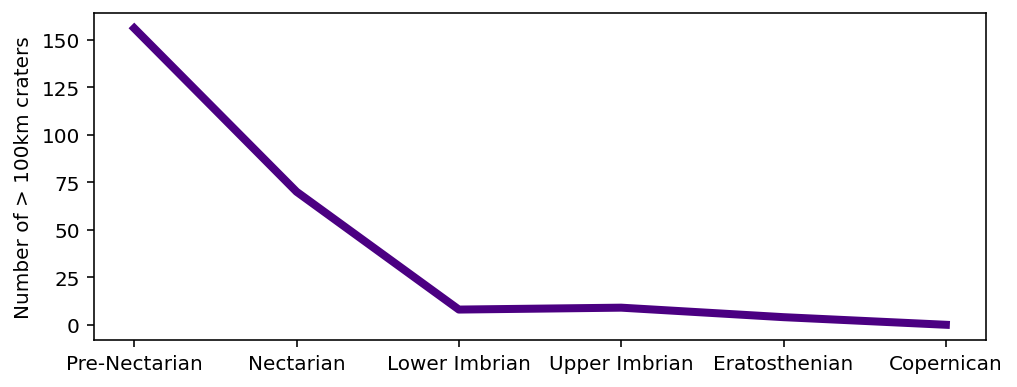

In [33]:
#frequency of large impacts per era
fig1, ax = plt.subplots(figsize=(8, 3))
age_100 = np.zeros(6)
for i in range (6):
    trunc_100 = age_sort[i][:, 2] >= 100
    age_100[i] = len(age_sort[i][:, 2][trunc_100])
plt.plot(labels_ages, age_100, color = 'indigo', linewidth = 4)
plt.ylabel('Number of > 100km craters')
plt.show()

In [34]:
%%time
#bootstrapping!!! Use existing distribution of crater diameters,
#but completely randomize their locations according to a uniform distribution
#(correcting for weirdness of latitude)
#we can use this as a test distribution to see if the std of location maps
#are unusually large
trials = 5000
size = np.shape(trunc_data[: , 2])
stds = np.zeros(trials)
for i in range(0, trials):
    new_longs = np.random.uniform(-180, 180, size)
    new_lats_uniform = np.random.uniform(-90, 90, size)
    new_lats = np.sin(np.pi*new_lats_uniform/180)*90
    new_diams = np.copy(trunc_data[: , 2])
    new_data = np.vstack((new_longs, new_lats, new_diams))
    new_data = new_data.transpose()
    new_map = frequency_map(long_divs, lat_divs, new_data)
    stds[i] = np.std(new_map)

CPU times: user 29min 10s, sys: 12.7 s, total: 29min 22s
Wall time: 30min 47s


In [35]:
#calculate mean and std of the distribution of the std
stds_mean = np.mean(stds)
stds_std = np.std(stds)

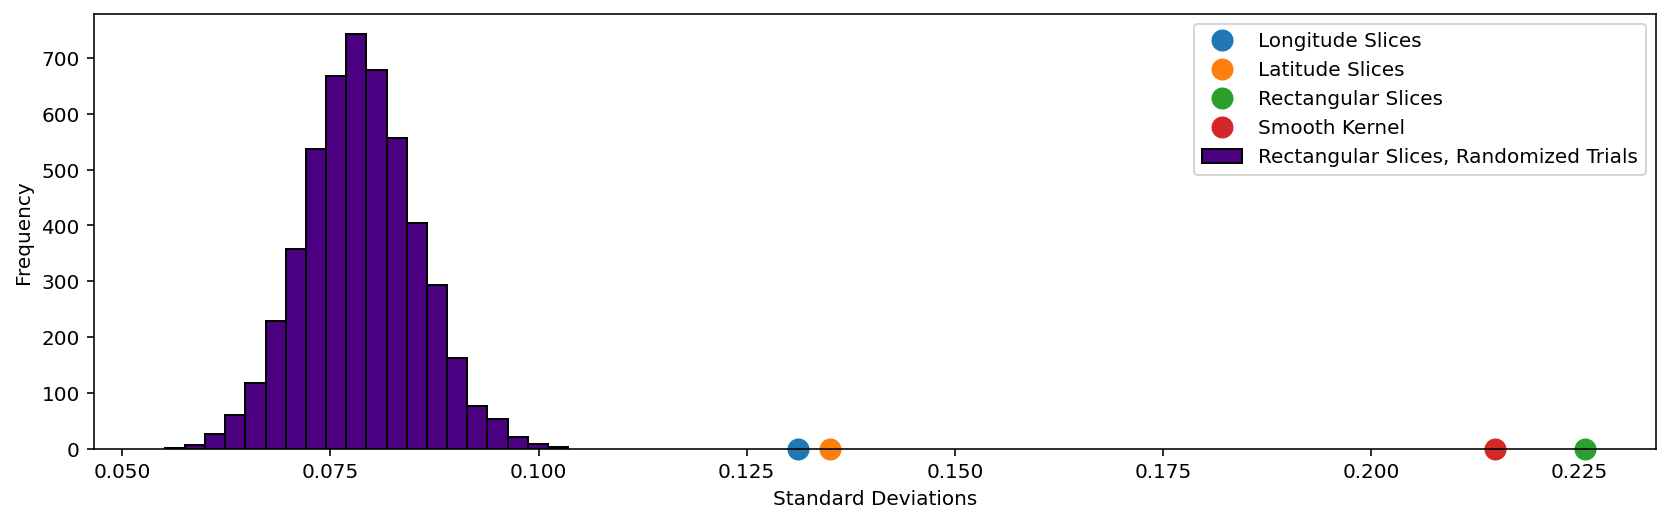

In [40]:
#plot histogram of std values compared to std of original data with each form of slicing
fig1, ax = plt.subplots(figsize=(14, 4))
plt.hist(stds, bins = 20, color = 'indigo', edgecolor='black', label = 'Rectangular Slices, Randomized Trials')
plt.xlabel('Standard Deviations')
plt.ylabel('Frequency')
plt.plot(std_long, 0, 'o', markersize = 10, clip_on = False, label = 'Longitude Slices')
plt.plot(std_lat, 0, 'o', markersize = 10, clip_on = False, label = 'Latitude Slices')
plt.plot(std_sq, 0, 'o', markersize = 10, clip_on = False, label = 'Rectangular Slices')
plt.plot(std_smooth, 0, 'o', markersize = 10, clip_on = False, label = 'Smooth Kernel')

plt.legend()
plt.savefig('10.pdf')
plt.show()

In [37]:
p_value_long = stat.norm.sf(std_long, loc = stds_mean, scale = stds_std)
p_value_lat = stat.norm.sf(std_lat, loc = stds_mean, scale = stds_std)
p_value_sq = stat.norm.sf(std_sq, loc = stds_mean, scale = stds_std)
p_value_smooth = stat.norm.sf(std_smooth, loc = stds_mean, scale = stds_std)

In [38]:
# print it!
print ("Subdivisions\t|\tp-value from normal distribution")
print("--------------------------------------------------------")
print (f'Longitudinal\t|\t{p_value_long}')
print (f'Latitudinal\t|\t{p_value_lat}')
print (f'Both\t\t|\t{p_value_sq}')
print (f'Smooth-Kernel\t|\t{p_value_smooth}')



Subdivisions	|	p-value from normal distribution
--------------------------------------------------------
Longitudinal	|	3.78697635654921e-15
Latitudinal	|	3.400458749684014e-17
Both		|	1.2958926600115201e-105
Smooth-Kernel	|	6.881825904908279e-91


In [39]:
%history

#import data, modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.optimize as opt
import scipy.stats as stat
#data = open()
#name   longitude   latitude    diameter [km]
data = np.genfromtxt("lunar_craters.dat", delimiter=',')
data = data[: , 1:4]
long = data[: , 0]
lat = data[: , 1]
diameter = data[: , 2]
#truncate data so we only have diameters above 10km, for which the dataset is complete
trunc = diameter >= 10
trunc_data = data[trunc]
diameter_trunc = trunc_data[: , 2]
#truncate the high values of the diameters, just for purposes of the histogram
trunc_high = diameter_trunc <= 200
trunc_high_data = trunc_data[trunc_high]
diameter_trunc_high = trunc_high_data[: , 2]
#plot histogram to show distribution of diameters
fig1, ax = plt.subplots()
def setaxparams(): #axi